In [9]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

C:\Users\nicol\AppData\Local\Temp\ipykernel_25924\3161807528.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [11]:
# Some functions to help out with
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'close', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

#Scaled Exponentially-Regularized Linear Unit to try out - if anyone can make this work, let me know.

# def serlu(x, lambdaa=1.07862, alphaa=2.90427):
#     result = tf.cond(x >= 0, lambda: tf.math.multiply(lambdaa, x), lambda: tf.math.multiply(lambdaa, alphaa, x, tf.exp(x)))
#     return result

# Get the Data

In [16]:
# # Choose a stock symbol
symbol_to_fetch = 'MSFT'
# Choose a date range
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')
# stock['return'] = stock['Close'].pct_change(1)
# for i in stock.index[1:]:
#     if (stock['return'].iloc[i] > 0 and stock['return'].iloc[i-1] < 0) or (stock['return'].iloc[i] < 0 and stock['return'].iloc[i-1] > 0):
#         stock['reversal'].iloc[i] = 1
#     else:
#         stock['reversal'].iloc[i] = 0
stock['Symbol'] = symbol_to_fetch
stock.tail()
#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch

stock['Close'].tail()

DateTime
2023-04-05 15:30:00    284.339996
2023-04-06 15:30:00    291.600006
2023-04-10 15:30:00    289.390015
2023-04-11 15:30:00    282.829987
2023-04-12 15:30:00    283.489990
Name: Close, dtype: float64

In [17]:
# Choose a stock symbol
symbol_to_fetch = 'MSFT'
# Choose a date range
start_date = str(datetime(2017, 1, 1).date())
end_date = str(datetime(2021, 2, 18).date())
# end_date = datetime.now().strftime('%Y-%m-%d'

In [18]:
# We have chosen the target as 'Close' attribute for prices. Let's see what it looks like
target = 'Close' # this is accessed by .iloc[:,3:4].values below
train_start_date = start_date
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'
training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values 
test_set = stock[test_start_date:].iloc[:,3:4].values

test_set_return = stock[test_start_date:].iloc[:,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(1510, 1)
(69, 1)


In [19]:
# Define S&P500 tickers
tickers_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers_table = pd.read_html(tickers_url, header=0)[0]
tickers = tickers_table['Symbol'].tolist()

# save tickers as a csv file
tickers_table.to_csv('sp500_tickers.csv')
# save tickers as a sqlite database
conn = sqlite3.connect('sp500_tickers.db')

In [18]:
import sqlite3
import numpy as np
from datetime import datetime

# Connect to the SQLite database
conn = sqlite3.connect('stock.db')
cursor = conn.cursor()

# Define the start and end dates of the training set
train_start_date = '2023-01-03'
train_end_date = '2023-02-28'

# Retrieve the data from the database
cursor.execute("SELECT * FROM stocks")
rows = cursor.fetchall()

training_set = None

# Loop through each row in the result set
for row in rows:
    try:
        date_str = row[0]
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        ticker = row[1]
        open_price = row[2]
        low_price = row[3]
        high_price = row[4]
        close_price = row[5]
        volume = row[6]
        sector = row[7]
        pe_ratio = row[8]
        
        # Check if the date is within the training range
        if train_start_date <= date_str <= train_end_date:
            new_training_set = np.array([[close_price]])
            if training_set is None:
                training_set = new_training_set
            else:
                training_set = np.concatenate([training_set, new_training_set], axis=0)
    except:
        continue

print(training_set.shape)




(58383, 1)


In [19]:
training_set

array([[122.47000122],
       [125.15000153],
       [122.95999908],
       ...,
       [166.33000183],
       [165.47000122],
       [167.        ]])

In [1]:
import sqlite3
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('stock.db')
cursor = conn.cursor()

# Define the start and end dates of the training set
train_start_date = '2023-01-03'
train_end_date = '2023-02-28'

# Define the start date of the test set
test_start_date = '2023-03-01'

# Retrieve the data from the database
cursor.execute("SELECT date, ticker, open, low, high, close, volume, sector, pe_ratio FROM stocks")
rows = cursor.fetchall()

training_set = None

# Loop through each row in the result set
for row in rows:
    try:
        date_str = row[0]
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        ticker = row[1]
        open_price = row[2]
        low_price = row[3]
        high_price = row[4]
        close_price = row[5]
        volume = row[6]
        sector = row[7]
        pe_ratio = row[8]
        
        # Check if the date is within the training range
        if train_start_date <= date_str <= train_end_date:
            new_training_set = np.array([[ticker, open_price, low_price, high_price, close_price, pe_ratio]])
            if training_set is None:
                training_set = new_training_set
            else:
                training_set = np.concatenate([training_set, new_training_set], axis=0)
    except:
        continue

print(training_set.shape)



(58383, 6)


In [3]:
training_set

array([['MMM', '121.5199966430664', '120.37000274658205',
        '122.63999938964844', '122.47000122070312', '12.066009972483066'],
       ['MMM', '123.3499984741211', '122.70999908447266',
        '125.29000091552734', '125.1500015258789', '12.33004941141664'],
       ['MMM', '124.20999908447266', '122.45999908447266',
        '124.56999969482422', '122.95999908447266', '12.114285624085976'],
       ...,
       ['ZTS', '167.0', '163.91000366210938', '168.07000732421875',
        '166.3300018310547', '36.96222262912326'],
       ['ZTS', '168.0', '164.99000549316406', '168.41000366210938',
        '165.47000122070312', '36.77111138237847'],
       ['ZTS', '165.1999969482422', '165.0399932861328',
        '168.5500030517578', '167.0', '37.111111111111114']], dtype='<U32')

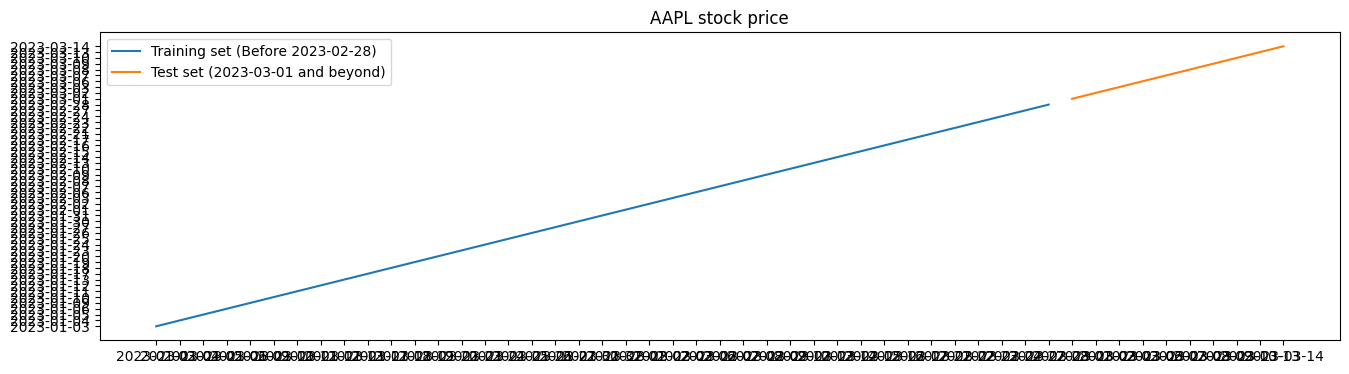

In [5]:
# Define the target stock to plot
target = 'AAPL'

# Plot the training and test sets
cursor.execute(f"SELECT date, * FROM stocks WHERE date BETWEEN '{train_start_date}' AND '{train_end_date}'")
train_data = cursor.fetchall()
train_data = np.array(train_data)

cursor.execute(f"SELECT date, * FROM stocks WHERE date >= '{test_start_date}'")
test_data = cursor.fetchall()
test_data = np.array(test_data)

plt.figure(figsize=(16,4))
plt.plot(train_data[:,0], train_data[:,1], label=f'Training set (Before {train_end_date})')
plt.plot(test_data[:,0], test_data[:,1], label=f'Test set ({test_start_date} and beyond)')
plt.legend()
plt.title(f'{target} stock price')
plt.show()


In [21]:
# #let's try adding multiple stocks in the training set... Like everything in the SPY holdings to see if that improves our target
#connection = sqlite3.connect('sp500_tickers.db')
#connection.row_factory = sqlite3.Row
#cursor = connection.cursor()
#cursor.execute('MMM','AAPL','KO','MSFT','NVDA')
#cursor.execute("""
 #    SELECT symbol FROM sp500_tickers
# """)
#rows = cursor.fetchall()
import pandas as pd
import sqlite3

# Connect to the database
connection = sqlite3.connect('sp500_tickers.db')

# Get the S&P 500 tickers from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)[0]
tickers = table['Symbol'].tolist()

# Create the table
#cursor = connection.cursor()
#cursor.execute("CREATE TABLE sp500_tickers (symbol TEXT)")

# Insert the tickers into the table
for ticker in tickers:
    cursor.execute("INSERT INTO sp500_tickers VALUES (?)", (ticker,))
connection.commit()

# Close the connection
connection.close()
rows = cursor.fetchall()
for row in rows:
     try:
         symbol = row['symbol']
         print (symbol)
         symbol_to_fetch = symbol
         stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
         stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
         stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
         stock = stock.fillna(method="ffill", axis=0)
         stock = stock.fillna(method="bfill", axis=0)
         stock = stock.set_index('DateTime')
         new_training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values
         frames = [training_set, new_training_set]
         training_set = np.concatenate(frames, axis = 0)
     except:
         continue
print(training_set.shape)
# # This works best with a TPU and trains very fast so only around 10 epochs needed due to the 1.8 million sample.
# # Also it is possible to sort by sector - just add (WHERE sector = 'Information Technology') under
# # the SELECT line.

(1510, 1)


In [20]:
# Define the target stock to plot
target = 'AAPL'

# Plot the training and test sets
cursor.execute(f"SELECT date, {target} FROM stocks WHERE date BETWEEN '{train_start_date}' AND '{train_end_date}'")
train_data = cursor.fetchall()
train_data = np.array(train_data)

cursor.execute(f"SELECT date, {target} FROM stocks WHERE date >= '{test_start_date}'")
test_data = cursor.fetchall()
test_data = np.array(test_data)

plt.figure(figsize=(16,4))
plt.plot(train_data[:,0], train_data[:,1], label=f'Training set (Before {train_end_date})')
plt.plot(test_data[:,0], test_data[:,1], label=f'Test set ({test_start_date} and beyond)')
plt.legend()
plt.title(f'{target} stock price')
plt.show()

OperationalError: no such column: AAPL

In [12]:
import matplotlib.pyplot as plt

# Define the start and end dates of the test set
test_start_date = '2023-03-01'

# Plot the stock price for the specified company
plt.figure(figsize=(16,4))
plt.plot(stock[target][train_start_date:train_end_date], label=f'Training set (Before {train_end_date})')
plt.plot(stock[target][test_start_date:], label=f'Test set ({test_start_date} and beyond)')
plt.legend()
plt.title(f'{symbol_to_fetch} stock price')
plt.show()


NameError: name 'stock' is not defined

<Figure size 1600x400 with 0 Axes>

In [8]:
stock[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
stock[target][test_start_date:].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date} and beyond)'])
plt.title(f'{symbol_to_fetch} stock price')
plt.show()

NameError: name 'stock' is not defined

In [47]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [48]:
timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

# Notice how the first y_train value becomes the last X_train value for the next sample

[0.02081694 0.02129949 0.02116839 0.02163454 0.02205882 0.02182757
 0.02200966 0.02212438] 0.022086137740871134
[0.02129949 0.02116839 0.02163454 0.02205882 0.02182757 0.02200966
 0.02212438 0.02208614] 0.02213894367386736


In [49]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(19453, 8) (19453,)
(19453, 8, 1) (19453,)


In [50]:
print(x_train.shape, y_train.shape)
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(19453, 8, 1) (19453,)


# Build the Model

In [51]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [52]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [53]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3

In [54]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [55]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [56]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
779/779 [==============================] - 75s 83ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - lr: 1.0000e-06
Epoch 2/100
779/779 [==============================] - 67s 85ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 4.5820e-04 - val_mean_squared_error: 4.5820e-04 - lr: 3.4300e-05
Epoch 3/100
779/779 [==============================] - 65s 84ms/step - loss: 8.7801e-04 - mean_squared_error: 8.7801e-04 - val_loss: 4.1882e-04 - val_mean_squared_error: 4.1882e-04 - lr: 6.7600e-05
Epoch 4/100
779/779 [==============================] - 64s 82ms/step - loss: 6.7744e-04 - mean_squared_error: 6.7744e-04 - val_loss: 1.6148e-04 - val_mean_squared_error: 1.6148e-04 - lr: 1.0090e-04
Epoch 5/100
779/779 [==============================] - 65s 83ms/step - loss: 5.3672e-04 - mean_squared_error: 5.3672e-04 - val_loss: 1.3380e-04 - val_mean_squared_error: 1.3380e-04 - lr: 1.3420e-04
Epoch 6/100
779/779 [=============

# Evaluate Model

In [57]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock[target][:train_end_date],original_stock[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])

C:\Users\nicol\AppData\Local\Temp\ipykernel_2460\2928164322.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test)


IndexError: tuple index out of range